In [11]:
import sys
sys.path.append("..")

from tqdm import tqdm
import h5py

import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
from hpl.utils.postprocessing import (
    find_experiments_directories, 
    load_data_assimilation_network,
    load_parametrized_simulator,
    load_hydra_config,
    dictconfig_to_dataframe,
)

In [4]:
base_dir = "/gpfs/work/zinchenk/final_experiments/parameter_tuning_batch_norm"

In [5]:
hyda_experiments = find_experiments_directories([base_dir])

In [6]:
true = []
estimated = []
for path in hyda_experiments:
    config = load_hydra_config(path)
    training_data_path = config.datamodule.path_to_load_data
    with h5py.File(training_data_path) as file:
        true.append(file.attrs["forcing"])

    simulator = load_parametrized_simulator(path)
    estimated.append(simulator.forcing.item())
true_sorted = sorted(true)

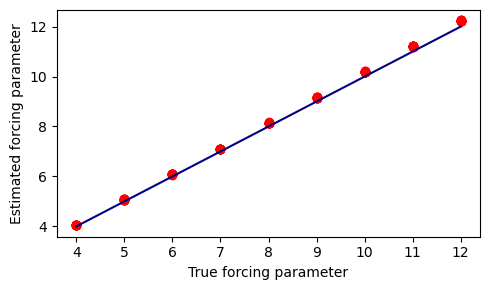

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(true_sorted, true_sorted, color="navy")
ax.scatter(true, estimated, color="red")
ax.set_ylabel("Estimated forcing parameter")
ax.set_xlabel("True forcing parameter")
plt.tight_layout()
plt.savefig("pt_evaluation.png", dpi=300)

In [8]:
df = pd.DataFrame({"true": true, "estim": estimated})

In [9]:
true_sorted = sorted(df["true"].unique())
estim_mean = df.groupby("true").mean()["estim"].values
estim_std = df.groupby("true").std()["estim"].values

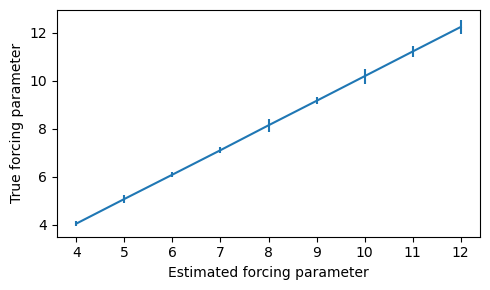

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# ax.plot(true_sorted, true_sorted, color="navy")
ax.errorbar(true_sorted, estim_mean, yerr=estim_std*20)

# ax.scatter(true, estimated, color="red")
ax.set_xlabel("Estimated forcing parameter")
ax.set_ylabel("True forcing parameter")
plt.tight_layout()
plt.savefig("pt_evaluation.png", dpi=300)

In [37]:
frame = {"true": true_sorted, "estim_mean": estim_mean, "estim_std": estim_std}
frame = pd.DataFrame(frame)
frame

,true,estim_mean,estim_std
0,4.0,4.048576,0.005776
1,5.0,5.073812,0.007834
2,6.0,6.086733,0.005790
3,7.0,7.104772,0.006676
4,8.0,8.139870,0.013011
5,9.0,9.158984,0.007220
6,10.0,10.184277,0.015261
7,11.0,11.211610,0.011057
8,12.0,12.232867,0.013786
